In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
import plotly.io as pio
import math

rcParams = {
    'xtick.labelsize': 12,
    'axes.titlesize': 28,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'lines.linewidth': 2
}
sns.set_context("paper", font_scale=2, rc=rcParams)

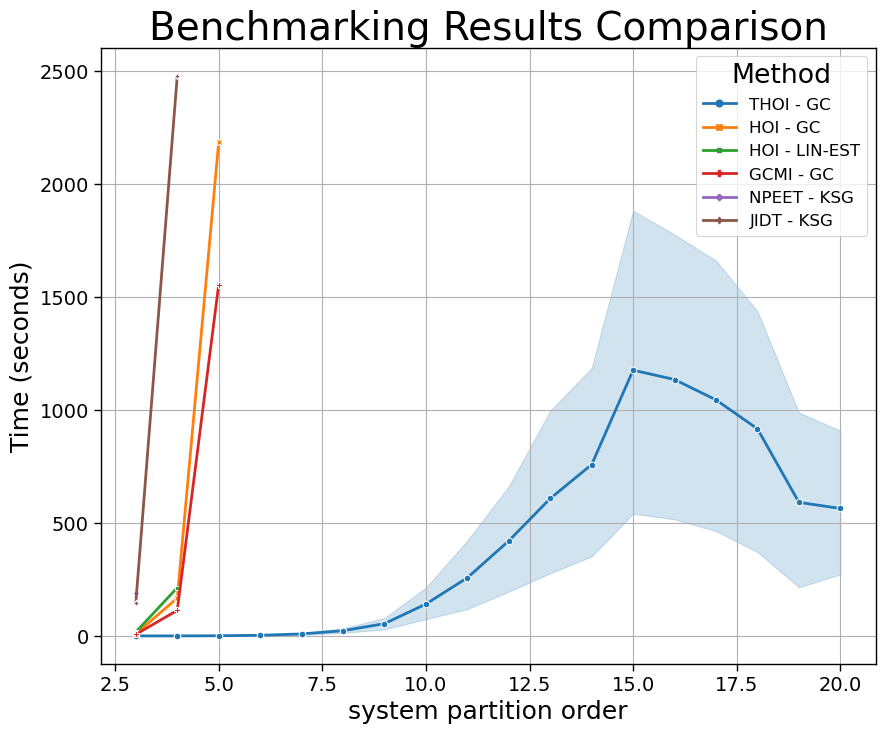

In [2]:
# Define the file paths
file_paths = [
    "library-thoi_estimator-gc.tsv",
    "library-hoi_estimator-gc.tsv",
    "library-hoi_estimator-linest.tsv",
    "library-gcmi_estimator-gc.tsv",
    "library-npeet_estimator-ksg.tsv",
    "library-jdit_estimator-ksg.tsv"
]

# Read each file into a DataFrame and assign a 'Method' column
dataframes = []
for path in file_paths:
    df = pd.read_csv(os.path.join('../benchmarking/results/times/',path), sep="\t")
    dataframes.append(df)

# Combine all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df['library-estimator'] = combined_df['library'] + ' - ' + combined_df['estimator']

# Create a line plot using Seaborn
plt.figure(figsize=(10, 8))
sns.lineplot(
    data=combined_df, x="order", y="time",
    hue="library-estimator", style='library-estimator',
    markers=True, dashes=False
)

plt.title('Benchmarking Results Comparison')
plt.xlabel('system partition order')
plt.ylabel('Time (seconds)')
plt.legend(title='Method')
plt.grid(True)

plt.savefig('./figures/times/benchmarking.pdf', format='pdf')
plt.show()

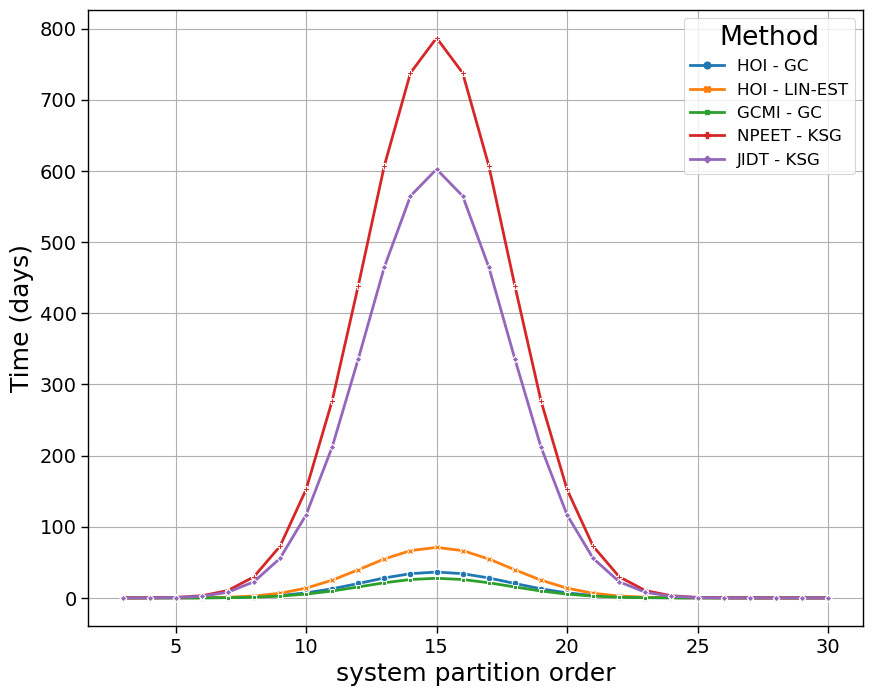

('HOI', 'GC')
time order 15: 0 days
0 days
('HOI', 'LIN-EST')
time order 15: 0 days
0 days
('GCMI', 'GC')
time order 15: 0 days
0 days
('NPEET', 'KSG')
time order 15: 0 days
0 days
('JIDT', 'KSG')
time order 15: 0 days
0 days


In [3]:
def estimated_computation_time(time_order_3, order):
    # assumes a system of 30 variables and 100000 samples
    nplet_time = time_order_3 / math.comb(30,2)
    return math.comb(30, order) * nplet_time


def get_triplet_time_from_df(df, library, estimator):
    return df[(df.library == library) & (df.estimator == estimator) & (df['T'] == 1000) & (df.order == 3)]['time'].values[0]

triplets_times = {
    ('HOI','GC'): get_triplet_time_from_df(combined_df, 'HOI', 'GC'),
    ('HOI', 'LIN-EST'): get_triplet_time_from_df(combined_df, 'HOI', 'LIN-EST'),
    ('GCMI', 'GC'): get_triplet_time_from_df(combined_df, 'GCMI', 'GC'),
    ('NPEET', 'KSG'): get_triplet_time_from_df(combined_df, 'NPEET', 'KSG'),
    ('JIDT', 'KSG'): get_triplet_time_from_df(combined_df, 'JIDT', 'KSG')
}

dfs = []
for (library, estimator), tuple_t in triplets_times.items():
    df = pd.DataFrame({
        'time': [estimated_computation_time(tuple_t,k) for k in range(3,31)],
        'order': list(range(3,31))
    })
    df['library'] = library
    df['estimator'] = estimator
    df['T'] = 1000
    df['N'] = 30
    dfs.append(df)


# Combine all dataframes into one
df = pd.concat(dfs, ignore_index=True)
df['library-estimator'] = df['library'] + ' - ' + df['estimator']
df['time'] = df['time'] / 60 / 60 / 24


# Create a line plot using Seaborn
plt.figure(figsize=(10, 8))
sns.lineplot(
    data=df, x="order", y="time",
    hue="library-estimator", style='library-estimator',
    markers=True, dashes=False
)

plt.title('')
plt.xlabel('system partition order')
plt.ylabel('Time (days)')
plt.legend(title='Method')
plt.grid(True)

plt.savefig('./figures/times/benchmarking_estimation.pdf', format='pdf')
plt.show()

for k in triplets_times.keys():
    print(k)
    library, estimator = k
    df_lib = df[(df.library == library) & (df.estimator == estimator)]
    print('time order 15:', math.floor(df_lib[df_lib.order == 15]['time'].values[0] / 60 / 60 / 24), 'days')
    print(math.floor(df_lib['time'].sum() / 60 / 60 / 24), 'days')

In [5]:
# Read the data
df = pd.read_csv('../benchmarking/results/times/library-thoi_estimator-gc.tsv', sep='\t')
df = df[['N', 'order', 'batch_size', 'time']]

# Create the list of dimensions with correct ranges
dimensions = []
for column in df.columns:
    if column != 'time':
        dimensions.append(
            dict(
                range=[df[column].min(), df[column].max()],
                label=column, values=df[column]
            )
        )

# Create the parallel coordinate plot
fig = go.Figure(data=
    go.Parcoords(
        line=dict(
            color=df['time'],
            colorscale='Solar',
            showscale=True,
            cmin=df['time'].min(),
            cmax=df['time'].max()
        ),
        dimensions=dimensions
    )
)

# Update the layout to match the rcParams
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(
        size=18  # Equivalent to 'axes.labelsize' in rcParams
    ),
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50
    ),
    coloraxis_colorbar=dict(
        title='Time',
        titleside='right',
        titlefont=dict(size=18),  # Equivalent to 'axes.labelsize'
        tickfont=dict(size=14)  # Equivalent to 'xtick.labelsize' and 'ytick.labelsize'
    )
)

# Update the colorbar tick labels and title size
fig.update_traces(
    selector=dict(type='parcoords'),
    line_colorbar=dict(
        title=dict(
            text='Time (seconds)',
            font=dict(size=18)  # Equivalent to 'axes.labelsize'
        ),
        tickfont=dict(size=14)  # Equivalent to 'xtick.labelsize' and 'ytick.labelsize'
    )
)


# Export the figure as a PDF
pio.write_image(fig, './figures/times/parameters_evaluation.pdf', format='pdf')

fig.show()